In [ ]:
#-----------------------------------------------------------------------------------

In [5]:
!pip install einops

In [6]:
import torch
from torchvision.datasets import CIFAR10
import matplotlib.pyplot as plt
from random import random
from torchvision.transforms import Resize, ToTensor
from torchvision.transforms.functional import to_pil_image
from torchvision.transforms import ToPILImage
from einops.layers.torch import Rearrange
from torch import Tensor
import math
from dataclasses import dataclass
import torch.nn as nn
from torch.nn import functional as F
from einops import rearrange
from einops import repeat
from torch.utils.data import random_split
from torch.utils.data import DataLoader

In [7]:

to_tensor = [Resize((144, 144)), ToTensor()]

class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image):
        for t in self.transforms: # making sure both the transformations happen sequentially in the pipeline
            image = t(image)
        return image

dataset = CIFAR10(root=".", download=True, transform=Compose(to_tensor)) #download in the same directory
print(type(dataset))

Files already downloaded and verified
<class 'torchvision.datasets.cifar.CIFAR10'>


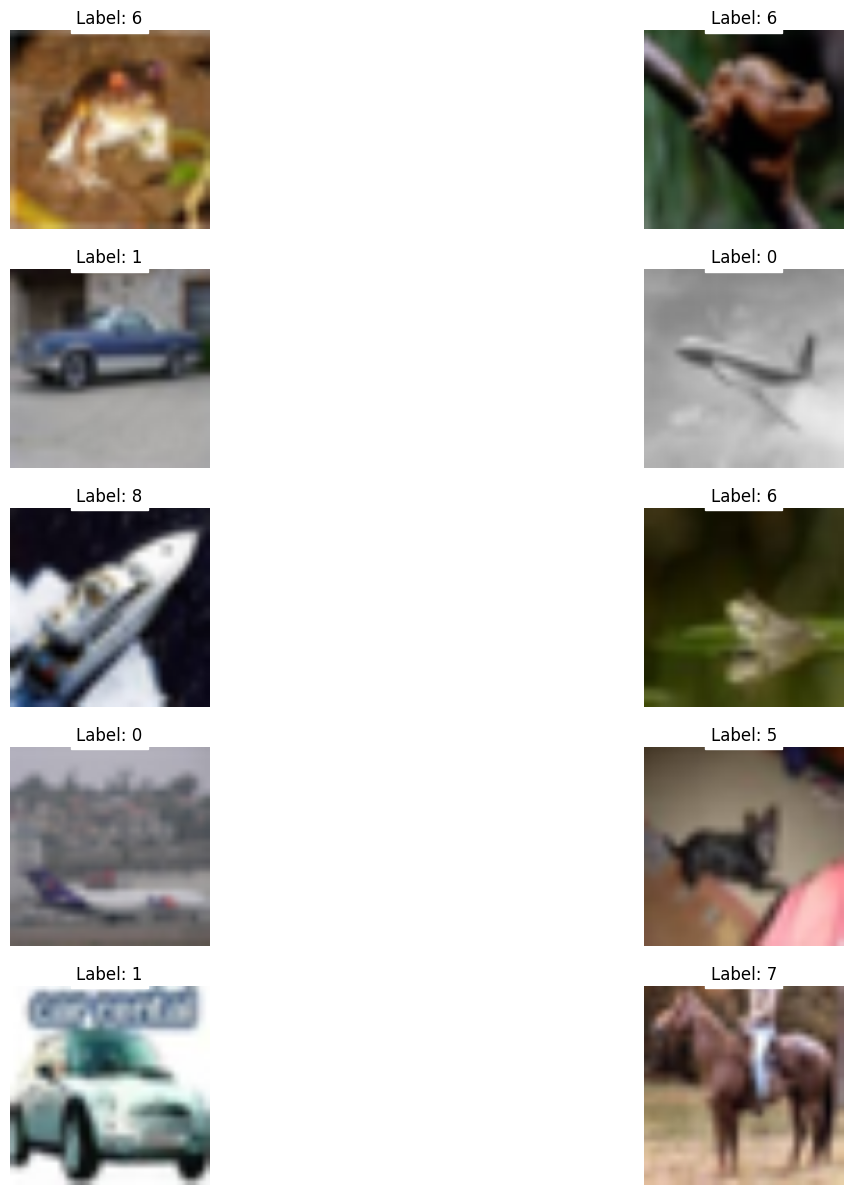

In [8]:
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage

def show_images(dataset, num_samples=10, cols=2):
    plt.figure(figsize=(15, 15))  # Set up the canvas for the grid

    # Calculate the number of rows needed
    rows = (num_samples + cols - 1) // cols

    # Initialize ToPILImage transform to convert tensors to PIL images for plotting
    to_pil_image = ToPILImage()

    # Ensure num_samples does not exceed the length of the dataset
    num_samples = min(num_samples, len(dataset))

    # Select indices evenly spaced across the dataset
    indices = [i * max(1, len(dataset) // num_samples) for i in range(num_samples)]

    for i, idx in enumerate(indices):
        img, target = dataset[idx]
        plt.subplot(rows, cols, i + 1)
        plt.imshow(to_pil_image(img))
        plt.title(f'Label: {target}', fontsize=12, pad=5, color='black', backgroundcolor='white')
        plt.axis('off')  # Turn off axes for cleaner visualization

    plt.show()

# Call the function to display images
show_images(dataset, num_samples=10, cols=2)


In [10]:
class Config:
  # patch_size=4
   #emb_size=16
   #n_head=4
   #ch=3
   #img_size=144,
   #n_layers=4
   #out_dim=43
   #dropout=0.0
    patch_size = 16
    emb_size = 256
    n_head = 8
    ch = 3
    img_size = 144
    n_layers = 12
    out_dim = 10     # Number of output classes.
    dropout = 0.1




In [11]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels=Config.ch, patch_size=Config.patch_size, emb_size=Config.emb_size):
        super().__init__()
        self.patch_size = patch_size
        self.projection = nn.Sequential(
            # break-down the image in s1 x s2 patches and flat them
            # rearranges it from batch channel length width to batch, number of patches, flatened size of each patch
            nn.Linear(patch_size * patch_size * in_channels, emb_size)
            )
    def forward(self, x):
        x = rearrange(x, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=self.patch_size, p2=self.patch_size)
        x = self.projection(x)
        return x

In [12]:
class SelfAttention(nn.Module):

    def __init__(self, n_embd=Config.emb_size, n_head=Config.n_head):
        super().__init__()
        assert n_embd % n_head == 0
        self.c_attn = nn.Linear(n_embd, 3 * n_embd)
        self.c_proj = nn.Linear(n_embd, n_embd)
        self.c_proj.NANOGPT_SCALE_INIT = 1
        self.n_head = n_head
        self.n_embd = n_embd

    def forward(self, x): # say input is (1, 5, 128)
        B, T, C = x.size() #Batch, sequence length, embedding dimension (1,5,128)
        qkv = self.c_attn(x) # Batch, sequence length, embedding dimension *3 (1,5,384)
        q,k,v = qkv.split(self.n_embd, dim=2) # splits qkv into 3 tensors along the 3rd dimension so each has shape [1, 5, 128]
        # We view qkv as Batch size, number of self-attention heads, T(sequence length), and number of dimensions per head
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1,2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1,2)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1,2)
        # (B, h, T, hs) * (B, h, hs, T) --> (B, h, hs, hs)
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = F.softmax(att, dim=-1) # convert the attention scores into probabilites
        y = att @ v # (B, h, hs, hs) * (B, h, hs, hs) -> (B, nh, T, hs)
        # After computing the attention output for each head, the heads are combined back into the original embedding dimension by reshaping:
        y = y.transpose(1, 2).contiguous().view(B, T, C)
        y = self.c_proj(y)
        return y

In [13]:
class MLP(nn.Module):
    def __init__(self, n_embd=Config.emb_size):
        super().__init__()
        self.c_fc = nn.Linear(n_embd, 4*n_embd)
        self.gelu = nn.GELU()
        self.c_proj = nn.Linear(4*n_embd, n_embd)
        self.c_proj.NANOGPT_SCALE_INIT = 1

    def forward(self,x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        return x

#---------------------------------------------------------------------------------------------------


class Block(nn.Module):
    def __init__(self, n_embd=Config.emb_size):
        super().__init__()
        self.ln1 =  nn.LayerNorm(n_embd)
        self.attn = SelfAttention(n_embd)
        self.ln2 =  nn.LayerNorm(n_embd)
        self.mlp  = MLP(n_embd)

    def forward(self, x):
        x = x + self.attn(self.ln1(x)) # residual connections
        x = x + self.mlp (self.ln2(x))
        return x




In [36]:
class ViT(nn.Module):
    def __init__(self, ch=Config.ch, img_size=Config.img_size, patch_size=Config.patch_size, emb_dim=Config.emb_size, n_layers=Config.n_layers, out_dim=Config.out_dim, dropout=Config.dropout, heads=Config.n_head):
        super(ViT, self).__init__()
        self.channels = ch
        self.height = img_size
        self.width = img_size
        self.patch_size = patch_size
        self.n_layers = n_layers

        self.patchEmbedding = PatchEmbedding(
            in_channels=ch,
            patch_size=patch_size,
            emb_size=emb_dim
        )
        num_patches = (img_size // patch_size) ** 2
        self.positional_emb = nn.Parameter(torch.randn(1, num_patches + 1, emb_dim))
        self.cls_token = nn.Parameter(torch.rand(1, 1, emb_dim))

        self.transformer = nn.ModuleList([Block(emb_dim) for _ in range(n_layers)])
        self.ln = nn.LayerNorm(emb_dim)
        self.lm_head = nn.Linear(emb_dim, out_dim, bias=False)

    def forward(self, img):
        x = self.patchEmbedding(img)
        B, T, C = x.shape
        cls_tokens = repeat(self.cls_token, '1 1 d -> b 1 d', b=B)
        x = torch.cat([cls_tokens, x], dim=1)
        x += self.positional_emb[:, :(T + 1)]

        for block in self.transformer:
            x = block(x)

        x = self.ln(x)
        logits = self.lm_head(x[:, 0])  # [CLS] token output for classification
        return logits



In [37]:
sample_datapoint = torch.unsqueeze(torch.rand(3, 144, 144), 0)  # A dummy image tensor for testing
vit_model = ViT()
logits = vit_model(sample_datapoint)
print(logits)


tensor([[-0.2572,  0.0274,  0.2642,  0.6116,  0.4856, -0.7138, -0.1435,  0.1061,
          0.6585, -0.7145]], grad_fn=<MmBackward0>)


In [38]:
len(dataset)

50000

In [39]:
from torch.utils.data import random_split

def load_split_data(dataset, split_ratio=0.8):
    total_samples = len(dataset)
    training_amount = int(split_ratio * total_samples)
    validation_amount = total_samples - training_amount

    # Split the dataset into training and validation sets
    train_dataset, val_dataset = random_split(dataset, [training_amount, validation_amount])

    return train_dataset, val_dataset


In [40]:
train_dataset, val_dataset = load_split_data(dataset)

In [41]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

def calculate_validation_loss(model, val_loader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    running_loss = 0.0
    total_samples = 0

    with torch.no_grad():  # No need to track gradients for validation
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_loss += loss.item() * inputs.size(0)
            total_samples += inputs.size(0)

    avg_loss = running_loss / total_samples
    return avg_loss



In [42]:
import os
from torch.optim.lr_scheduler import CosineAnnealingLR

# Model, optimizer, criterion
model = ViT()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

# Parameters
epochs = 10  # Number of epochs to run
loss_per_epoch = []
val_loss_per_epoch = []

# Scheduler for learning rate decay (decay every 2 epochs for example)
scheduler = CosineAnnealingLR(optimizer, T_max=epochs)

# Create a directory to save models
model_dir = 'saved_models_L2'
os.makedirs(model_dir, exist_ok=True)

# Prepare model for training
model.train()

# Loop over epochs
for epoch in range(epochs):
    epoch_loss = 0.0  # Accumulate loss for the epoch
    num_batches = 0   # Track the number of batches in each epoch

    print(f"Epoch [{epoch+1}/{epochs}]")

    # Loop over batches in the training data
    for Xb, Yb in train_dataloader:

        # Move data to GPU if available
        if torch.cuda.is_available():
            Xb, Yb = Xb.cuda(), Yb.cuda()
            model = model.cuda()

        # Forward pass
        logits = model(Xb)
        loss = criterion(logits, Yb)

        # Backward pass
        optimizer.zero_grad()  # Clear the gradients
        loss.backward()  # Backpropagation
        optimizer.step()  # Update the weights

        # Accumulate the total loss for this epoch
        epoch_loss += loss.item()
        num_batches += 1

    # Calculate the average loss for the epoch
    avg_epoch_loss = epoch_loss / num_batches
    loss_per_epoch.append(avg_epoch_loss)

    # Calculate validation loss
    avg_val_loss = calculate_validation_loss(model, val_loader, criterion, "cuda")
    val_loss_per_epoch.append(avg_val_loss)

    # Print the average loss for this epoch
    print(f"Epoch [{epoch+1}/{epochs}], Average Loss: {avg_epoch_loss:.4f}")

    # Step the scheduler after each epoch
    scheduler.step()


    if epoch % 5 == 0:
      # Save the model checkpoint
      model_path = os.path.join(model_dir, f'vit_model_epoch_{epoch+1}.pth')
      torch.save({
          'epoch': epoch + 1,
          'model_state_dict': model.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
          'scheduler_state_dict': scheduler.state_dict(),
          'loss': avg_epoch_loss,
      }, model_path)

      print(f"Model saved at {model_path}")

Epoch [1/10]
Epoch [1/10], Average Loss: 1.8549
Model saved at saved_models_L2/vit_model_epoch_1.pth
Epoch [2/10]
Epoch [2/10], Average Loss: 1.4346
Epoch [3/10]
Epoch [3/10], Average Loss: 1.2589
Epoch [4/10]
Epoch [4/10], Average Loss: 1.1295
Epoch [5/10]
Epoch [5/10], Average Loss: 1.0078
Epoch [6/10]
Epoch [6/10], Average Loss: 0.8803
Model saved at saved_models_L2/vit_model_epoch_6.pth
Epoch [7/10]
Epoch [7/10], Average Loss: 0.7480
Epoch [8/10]
Epoch [8/10], Average Loss: 0.6139
Epoch [9/10]
Epoch [9/10], Average Loss: 0.5053
Epoch [10/10]
Epoch [10/10], Average Loss: 0.4403


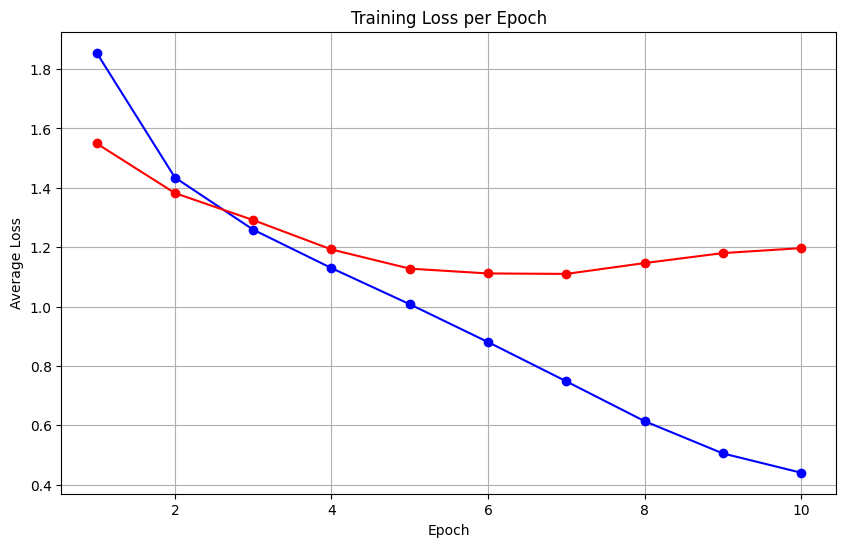

In [43]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), loss_per_epoch, marker='o', linestyle='-', color='b')
plt.plot(range(1, epochs + 1), val_loss_per_epoch, marker='o', linestyle='-', color='r')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('Training Loss per Epoch')
plt.grid(True)
plt.show()


In [44]:
def inference_in_batches(X, batch_size):
    model.eval()  # Set model to evaluation mode
    predicted_classes = []
    probabilities = []

    num_samples = X.size(0)

    with torch.no_grad():
        for start in range(0, num_samples, batch_size):
            end = min(start + batch_size, num_samples)
            batch_X = X[start:end]

            logits = model(batch_X)
            probs = torch.softmax(logits, dim=1)
            predicted_class = torch.argmax(probs, dim=1)

            predicted_classes.append(predicted_class)
            probabilities.append(probs)

    # Concatenate results from all batches
    predicted_classes = torch.cat(predicted_classes, dim=0)
    probabilities = torch.cat(probabilities, dim=0)

    return predicted_classes, probabilities

In [45]:
batch_size = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_samples = len(val_dataset)
Xtest = torch.zeros((num_samples, 3, 144, 144)).to(device)
Ytest = torch.zeros(num_samples, dtype=torch.long).to(device)


for i in range(num_samples):
    img, target = dataset[i]
    Xtest[i] = img.to(device)  # Store the image on GPU
    Ytest[i] = torch.tensor(target, dtype=torch.long).to(device)  # Convert target to tensor and move to GPU


# Run inference
predicted_class, probs = inference_in_batches(Xtest, batch_size)
print(predicted_class[:20])
target = torch.tensor(target, dtype=torch.long)
print(Ytest[:20])

print((predicted_class == Ytest).float().mean())



tensor([6, 9, 9, 4, 1, 1, 0, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 3, 6],
       device='cuda:0')
tensor([6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6],
       device='cuda:0')
tensor(0.8214, device='cuda:0')


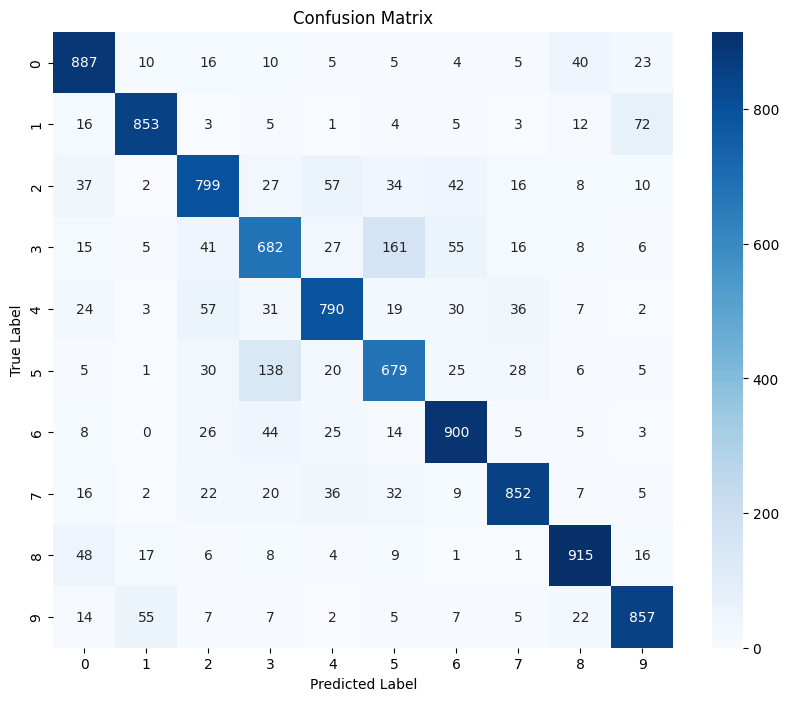

In [49]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

Ytest_np = Ytest.cpu().numpy()
predicted_class_np = predicted_class.cpu().numpy()

num_classes = 10
cm = confusion_matrix(Ytest_np, predicted_class_np, labels=list(range(num_classes)))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(range(num_classes)), yticklabels=list(range(num_classes)))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [50]:
import numpy as np
np.save('Ytest_np_after', Ytest_np)
np.save('predicted_class_np_after', predicted_class_np)


In [51]:
print(os.listdir(model_dir))

['vit_model_epoch_1.pth', 'vit_model_epoch_6.pth']


In [52]:
print("Current working directory:", os.getcwd())

# List all files and directories in the current working directory
print("Contents of current directory:", os.listdir(os.getcwd()))


Current working directory: /content
Contents of current directory: ['.config', 'saved_models_L2', 'predicted_class_np_after.npy', 'Ytest_np_after.npy', 'cifar-10-python.tar.gz', 'cifar-10-batches-py', 'sample_data']


In [53]:
from google.colab import files

# Path to the model file
model_file_path = '/content/saved_models_L2/vit_model_epoch_6.pth'

# Download the file
files.download(model_file_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>